In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.optim import AdamW
from tqdm import tqdm
from transformers import BertTokenizer,BertModel
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional
import transformers
from sklearn.linear_model import LogisticRegression
np.random.RandomState(seed=1)

RandomState(MT19937) at 0x178898340

In [2]:
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', '2*roc_auc-1', 'thrs', 'predicted'])
def evaluation(model_name, val, predicted, thrs=0.5):
    '''
    На вход - имя модели и метки, получившиеся после обучения модели, и метки валидационной выборки
    Возвращает таблицу с результатами results
    '''
    
    acc = metrics.accuracy_score(val, (predicted>thrs))
    pr = metrics.precision_score(val, (predicted>thrs))
    rec = metrics.recall_score(val, (predicted>thrs))
    f1 = metrics.f1_score(val, (predicted>thrs))
    roc_auc = metrics.roc_auc_score(val, predicted)
    roc_norm = roc_auc * 2 - 1
    
    results.loc[len(results)] = [model_name, acc, pr, rec, f1, roc_auc, roc_norm, thrs, predicted]

    
def plot(model_name, predicted, val, thrs=0.5):
    '''
    Рисует для конкретной модели roc и предсказания
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(val, predicted)
    
    A = np.array(predicted)
    idx_sig = np.where(val == 1)[0]
    idx_bkg = np.where(val == 0)[0]
    bins = 10
    
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,2,1)
    plt.plot(fpr,  tpr, '.')
    plt.title(model_name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    ax2 = plt.subplot(1,2,2)
    plt.hist(A[idx_sig], histtype='step', label='1', density=True, bins = bins)
    plt.hist(A[idx_bkg], histtype='step', label='0', density=True, bins = bins)
    plt.vlines(x=thrs, ymin=0, ymax=4, color='red', linestyle='--', label = 'threshold')
    plt.xlabel('prediction')
    plt.xticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), color='k', size=14)
    plt.legend(loc="upper right")
    plt.title(model_name)
    plt.show()
    plt.close('all') 


In [3]:
def plot_results():
    '''
    Рисует для всех моделей из results roc и предсказания
    '''
    preds = results.predicted.values
    name = results.model.values
    thrs = results.thrs.values
    for i in range(len(results)):
        plot(str(i) + ':' + name[i], preds[i], y_test, thrs[i])

## Ансамбль  сетей (текст и числовые параметры) + предобработка текста с помощьюBERT

In [4]:
data = pd.read_csv('/Users/nzaretski/Desktop/education/wildberies/script/wb_school/data/data_analysis.csv')
data = data[data.duplicated() == False].reset_index(drop=True)
data.drop(['id1', 'id2', 'id3'], axis=1, inplace=True)

data_in = data.copy()

In [5]:
data_text = data[['text', 'label']]

In [6]:
data_num = data.drop(['text'], axis=1)

In [7]:
text_train, text_test = train_test_split(
    data_text,
    test_size=0.3, 
    random_state=1,
    stratify=data_text.label
)

text_val, text_test = train_test_split(
    text_test,
    test_size=0.5, 
    random_state=1,
    stratify=text_test.label
)


num_train, num_test = train_test_split(
    data_num,
    test_size=0.3, 
    random_state=1,
    stratify=data_num.label
)

num_val, num_test = train_test_split(
    num_test,
    test_size=0.5, 
    random_state=1,
    stratify=num_test.label
)

text_train.reset_index(inplace=True, drop=True)
text_val.reset_index(inplace=True, drop=True)
text_test.reset_index(inplace=True, drop=True)

num_train.reset_index(inplace=True, drop=True)
num_val.reset_index(inplace=True, drop=True)
num_test.reset_index(inplace=True, drop=True)

### Text CNN

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
bert_model = BertModel.from_pretrained("bert-base-multilingual-uncased")

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def tokenize_text(df, max_seq_length):
    return [
        tokenizer.encode(str(text), add_special_tokens=True)[:max_seq_length] for text in df.text.values #!
    ]


def pad_text(tokenized_text, max_seq_length):
    return np.array([el + [0] * (max_seq_length - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq_length):
    tokenized_text = tokenize_text(df, max_seq_length)
    padded_text = pad_text(tokenized_text, max_seq_length)
    return torch.tensor(padded_text)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [10]:
max_seq_length = 40
train_indices = tokenize_and_pad_text(text_train, max_seq_length)
val_indices = tokenize_and_pad_text(text_val, max_seq_length)
test_indices = tokenize_and_pad_text(text_test, max_seq_length)

In [11]:
with torch.no_grad():
    x_train = bert_model(train_indices)[0]  # Models outputs are tuples
    x_val = bert_model(val_indices)[0]
    x_test = bert_model(test_indices)[0]

In [12]:
y_train = targets_to_tensor(text_train, 'label')
y_val = targets_to_tensor(text_val, 'label')
y_test = targets_to_tensor(text_test, 'label')

In [13]:
train_set = [
    (x_train[i], y_train[i]) for i in range(len(x_train))
]

val_set = [
    (x_val[i], y_val[i]) for i in range(len(x_val))
]

test_set = [
    (x_test[i], y_test[i]) for i in range(len(x_test))
]

In [14]:
batch_size = 32

loader  = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

loader_val  = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, drop_last=True
)

In [15]:
class BertCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout):
        super(BertCNN, self).__init__()

        embed_num = embed_num
        embed_dimension = embed_dim
        num_labels = class_num
        kernel_num = kernel_num
        kernal_sizes = kernel_sizes
        dropout = dropout

        self.embed = nn.Embedding(embed_num, embed_dimension)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_num, (k, embed_dim)) for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(len(kernel_sizes)*kernel_num, num_labels)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, inputs):
        output = Variable(inputs)
        output = inputs.unsqueeze(1)
        output = [nn.functional.relu(conv(output)).squeeze(3) for conv in self.convs]
        output = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in output]
        output = torch.cat(output, 1)
        output = self.dropout(output)
        logits = self.classifier(output)
        output = self.sigmoid(logits)
        return output

In [16]:
embed_num = max_seq_length
print(embed_num)
embed_dim = bert_model.config.hidden_size 
print(embed_dim)
class_num = 1
print(class_num)
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5


40
768
1


In [17]:
model = BertCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout
)

In [18]:
n_epochs = 200
learning_rate = 1e-3

In [19]:
train_losses = []
val_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [20]:
import time
for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0
    val_loss = 0

    model.train(True)
    for x_batch, y_batch in loader:
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = criterion(y_pred.squeeze(-1), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / x_batch.shape[0])
    elapsed = time.time() - start_time


    print(
        "Epoch %d Train loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1],  elapsed)
    )
    
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in loader_val:
            y_pred = model(x_batch)
            loss = criterion(y_pred.squeeze(-1), y_batch)
            val_loss += loss.item()
    val_losses.append(val_loss / x_batch.shape[0])

Epoch 1 Train loss: 1.40. Elapsed time: 1.38s.
Epoch 2 Train loss: 1.39. Elapsed time: 1.33s.
Epoch 3 Train loss: 1.36. Elapsed time: 1.29s.
Epoch 4 Train loss: 1.31. Elapsed time: 1.33s.
Epoch 5 Train loss: 1.32. Elapsed time: 1.34s.
Epoch 6 Train loss: 1.30. Elapsed time: 1.33s.
Epoch 7 Train loss: 1.28. Elapsed time: 1.33s.
Epoch 8 Train loss: 1.27. Elapsed time: 1.33s.
Epoch 9 Train loss: 1.25. Elapsed time: 1.35s.
Epoch 10 Train loss: 1.24. Elapsed time: 1.34s.
Epoch 11 Train loss: 1.22. Elapsed time: 1.31s.
Epoch 12 Train loss: 1.23. Elapsed time: 1.32s.
Epoch 13 Train loss: 1.19. Elapsed time: 1.36s.
Epoch 14 Train loss: 1.19. Elapsed time: 1.36s.
Epoch 15 Train loss: 1.18. Elapsed time: 1.31s.
Epoch 16 Train loss: 1.17. Elapsed time: 1.30s.
Epoch 17 Train loss: 1.16. Elapsed time: 1.31s.
Epoch 18 Train loss: 1.14. Elapsed time: 1.39s.
Epoch 19 Train loss: 1.12. Elapsed time: 1.34s.
Epoch 20 Train loss: 1.12. Elapsed time: 1.31s.
Epoch 21 Train loss: 1.10. Elapsed time: 1.35s.
E

Epoch 171 Train loss: 0.83. Elapsed time: 1.29s.
Epoch 172 Train loss: 0.84. Elapsed time: 1.32s.
Epoch 173 Train loss: 0.83. Elapsed time: 1.30s.
Epoch 174 Train loss: 0.86. Elapsed time: 1.29s.
Epoch 175 Train loss: 0.85. Elapsed time: 1.27s.
Epoch 176 Train loss: 0.81. Elapsed time: 1.30s.
Epoch 177 Train loss: 0.83. Elapsed time: 1.33s.
Epoch 178 Train loss: 0.82. Elapsed time: 1.32s.
Epoch 179 Train loss: 0.84. Elapsed time: 1.32s.
Epoch 180 Train loss: 0.84. Elapsed time: 1.31s.
Epoch 181 Train loss: 0.84. Elapsed time: 1.31s.
Epoch 182 Train loss: 0.83. Elapsed time: 1.31s.
Epoch 183 Train loss: 0.84. Elapsed time: 1.28s.
Epoch 184 Train loss: 0.84. Elapsed time: 1.30s.
Epoch 185 Train loss: 0.83. Elapsed time: 1.31s.
Epoch 186 Train loss: 0.86. Elapsed time: 1.28s.
Epoch 187 Train loss: 0.85. Elapsed time: 1.30s.
Epoch 188 Train loss: 0.84. Elapsed time: 1.30s.
Epoch 189 Train loss: 0.84. Elapsed time: 1.32s.
Epoch 190 Train loss: 0.82. Elapsed time: 1.30s.
Epoch 191 Train loss

In [21]:
val_losses

[0.2647523656487465,
 0.26440079510211945,
 0.25717546604573727,
 0.2602977529168129,
 0.2614366114139557,
 0.26102864369750023,
 0.25885373912751675,
 0.2622222751379013,
 0.25071842037141323,
 0.2559124808758497,
 0.2524354085326195,
 0.25294038746505976,
 0.2532254960387945,
 0.2509624771773815,
 0.253868879750371,
 0.24975878186523914,
 0.2522185267880559,
 0.24976101331412792,
 0.24925310723483562,
 0.25266311038285494,
 0.25353092700242996,
 0.24989824835211039,
 0.24956829845905304,
 0.25237886887043715,
 0.2568384222686291,
 0.253674304112792,
 0.2558050723746419,
 0.2551648309454322,
 0.2583198258653283,
 0.25709811970591545,
 0.25903990026563406,
 0.2587856901809573,
 0.25815266370773315,
 0.26316145434975624,
 0.2617707811295986,
 0.26407071109861135,
 0.2591436943039298,
 0.264086521230638,
 0.26512837409973145,
 0.26402626745402813,
 0.26351271104067564,
 0.26924092415720224,
 0.2655701767653227,
 0.2736919801682234,
 0.26994798704981804,
 0.274547235108912,
 0.27861030120

In [22]:
train_losses

[1.3957149563357234,
 1.394947687163949,
 1.3621475249528885,
 1.3076855866238475,
 1.3153193471953273,
 1.3046757820993662,
 1.2824820969253778,
 1.2660025171935558,
 1.2499934788793325,
 1.2362721432000399,
 1.222736514173448,
 1.2285802671685815,
 1.1908613285049796,
 1.1915683941915631,
 1.1841123197227716,
 1.1671702973544598,
 1.1593329245224595,
 1.1443028384819627,
 1.1197420582175255,
 1.1247922396287322,
 1.098743163049221,
 1.0911733247339725,
 1.0744112245738506,
 1.0629861382767558,
 1.0706298211589456,
 1.0447037387639284,
 1.0492201717570424,
 1.0490344623103738,
 1.0232471656054258,
 1.0299235517159104,
 1.0228331480175257,
 1.0170461954548955,
 1.0161570701748133,
 0.998240863904357,
 1.0013329228386283,
 1.00239338260144,
 0.9897931832820177,
 0.9867690391838551,
 0.9782510390505195,
 0.9859816692769527,
 0.9968841886147857,
 0.9612707598134875,
 0.9749230481684208,
 0.9611274898052216,
 0.9780658851377666,
 0.9720771797001362,
 0.9614219488576055,
 0.9500869791954756

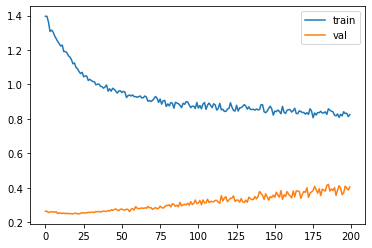

In [23]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()

In [24]:
pred_proba_text = model(x_test).detach().numpy()

In [25]:
evaluation('1.TextCNN', y_test.detach().numpy(), pred_proba_text, thrs=0.5)

In [26]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,1.TextCNN,0.705757,0.25,0.056452,0.092105,0.516842,0.033684,0.5,"[[0.30070913], [0.30070913], [0.0030671458], [..."


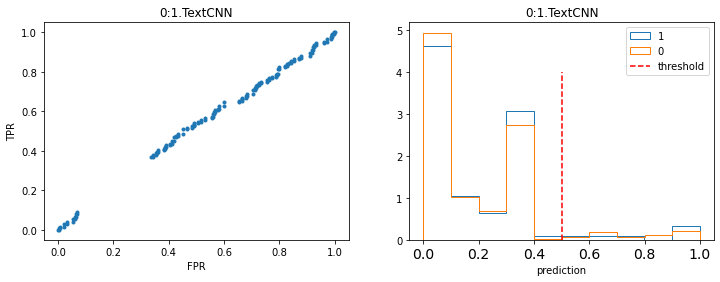

In [27]:
plot_results()

### Numeric

In [28]:
X_train = num_train.drop('label', axis=1)
y_train = num_train.label

X_test= num_test.drop('label', axis=1)
y_test = num_test.label

In [29]:
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)
preds_proba_num = model.predict_proba(X_test)[:, 1]


In [30]:
evaluation('2.LogisticRegr', y_test, preds_proba_num, thrs=0.5)  

### Ансамбль

In [31]:
preds_proba = 0.5 * (preds_proba_num + pred_proba_text.reshape(469))

In [32]:
evaluation('3.Ансамбль', y_test, preds_proba, thrs=0.5)  

In [33]:
######

In [34]:
results

,model,accuracy,precision,recall,f1,roc_auc,2*roc_auc-1,thrs,predicted
0,1.TextCNN,0.705757,0.250000,0.056452,0.092105,0.516842,0.033684,0.5,"[[0.30070913], [0.30070913], [0.0030671458], [..."
1,2.LogisticRegr,0.763326,0.740741,0.161290,0.264901,0.709888,0.419776,0.5,"[0.2022792451499657, 0.6019453126948088, 0.241..."
2,3.Ансамбль,0.727079,0.423077,0.088710,0.146667,0.648855,0.297709,0.5,"[0.25149418676489377, 0.4513272205373153, 0.12..."


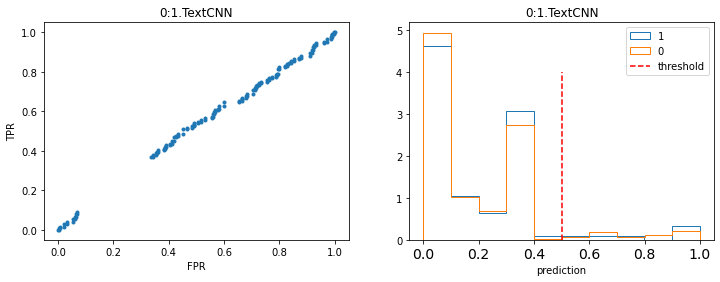

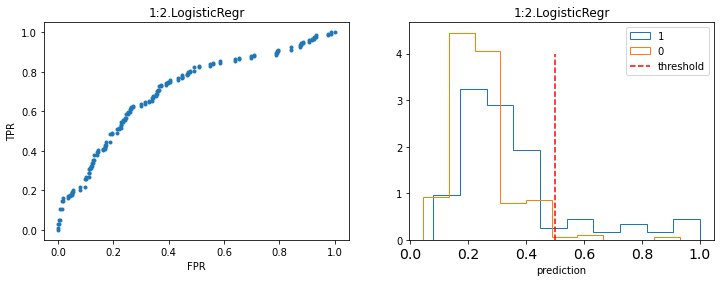

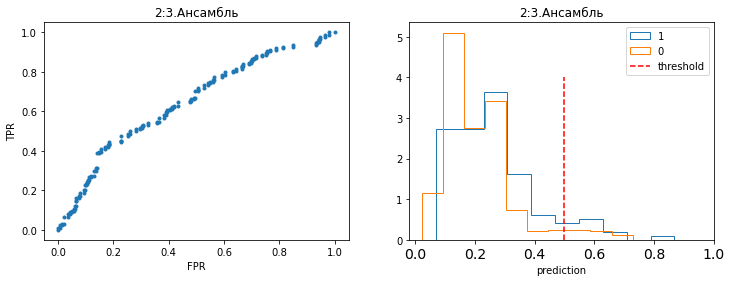

In [35]:
plot_results()

In [ ]:
# получилось плохо - будем использовать простые модели